In [6]:
import sqlite3
import pandas as pd
import parsl_analytics as pa
%matplotlib inline
%run '../bin/notebook_utils.py'
#%run 'bin/plot_utilization.py'
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # Expand the notebook to the width of the browser
plt.style.use('ggplot')

In [7]:
muds =  ['parsl.ws.1N.0000',
         'parsl.ws.1N.0001',
         'parsl.ws.1N.0002',
         'parsl.ws.2N.0002',
         'parsl.ws.2N.0000',
         'parsl.ws.2N.0001',
         'parsl.ws.18N.0001',
         'parsl.ws.18N.0000',
         'parsl.ws.18N.0002',
         'parsl.ws.36N.0000',
         'parsl.ws.36N.0001',
         'parsl.ws.36N.0002',
         'parsl.ws.72N.0000',
         'parsl.ws.72N.0001',
         'parsl.ws.72N.0002']

mdir = '/home/aymen/RADICAL/Parsl-RP/comet-test/Parsl/parsl_sessions/WS/'
mids = [mdir+m for m in muds]
ss = {}
t= 0

    # This chunck of code takes PARSL DB and trnaslate it to Panda Dataframe
    # We assume that Parsl_task_elapsed time is the (task_TX+task_TQ+task_sched)
    # We assume that Parsl_Workflow runtime is the (TTC) 
    # This is not accuarte way to calaulcate the TTX of the workload

for mid in muds:
    mp = mdir+mid+'/monitoring.db'
    conn = sqlite3.connect(mp)
    df_all = pd.read_sql_query("SELECT * FROM 'task'", conn)
    df_ttq = pa.get_queue_tstamps(mdir+mid+'/000/parsl.log')
    df_ttt = pd.read_sql_query("SELECT task_elapsed_time FROM 'task'", conn) #TTX + TTQ
    df_ttx = abs(df_ttt['task_elapsed_time'].max()-df_ttq)
    df_ttc = pd.read_sql_query('SELECT workflow_duration from workflow', conn)
    
    ss[mid] = {'session': muds[t]}
    ss[mid].update({'TTC': df_ttc['workflow_duration'][0]})
    ss[mid].update({'TTQ': df_ttq})
    ss[mid].update({'TTX': df_ttx})
    ss[mid].update({'OVH': df_ttc['workflow_duration'][0]-df_ttq-df_ttx})
    
    # This chunck of code takes PARSL DB and trnaslate it to RP prof 
    # This is the only valid way to calculate the TTX of the entire workload accuratley
    # using RADICAL-Analytics
    """
    for index, row in df_all.iterrows():
        exec_start = (str(pa.stamp_to_num(row['task_time_submitted'].split()[1]))+',unit.'+str(row['task_id'])+',exec_start'+',None')
        exec_stop  = (str(pa.stamp_to_num(row['task_time_returned'].split()[1]))+',unit.'+str(row['task_id'])+',exec_stop'+',None')
        with open(ss[mid]['session']+'.prof', 'a') as f:
            print(exec_start, file=f)
            print(exec_stop, file=f)
    """
    
    t=t+1

In [8]:
info = []

for mid in muds:
    info.append({'session':mid,
                 'Parsl TTQ':ss[mid]['TTQ'],
                 'Parsl TTC':ss[mid]['TTC'],
                 'Parsl TTX':ss[mid]['TTX'],
                 'Parsl OVH':ss[mid]['OVH']})
df_info = pd.DataFrame(info) 
df_info

,session,Parsl TTQ,Parsl TTC,Parsl TTX,Parsl OVH
0,parsl.ws.1N.0000,10.065,337.654527,314.561075,13.028452
1,parsl.ws.1N.0001,80.007,467.313456,331.602422,55.704034
2,parsl.ws.1N.0002,29.964,357.494191,315.629689,11.900502
3,parsl.ws.2N.0002,142.154,482.114615,327.752978,12.207637
4,parsl.ws.2N.0000,44.775,397.541135,322.128627,30.637508
5,parsl.ws.2N.0001,29.962,418.571998,338.668131,49.941867
6,parsl.ws.18N.0001,0.000,376.933595,363.400931,13.532664
7,parsl.ws.18N.0000,39.881,434.364346,382.652964,11.830382
8,parsl.ws.18N.0002,164.588,550.110582,376.390516,9.132066
9,parsl.ws.36N.0000,1360.723,1813.380684,418.237026,34.420658


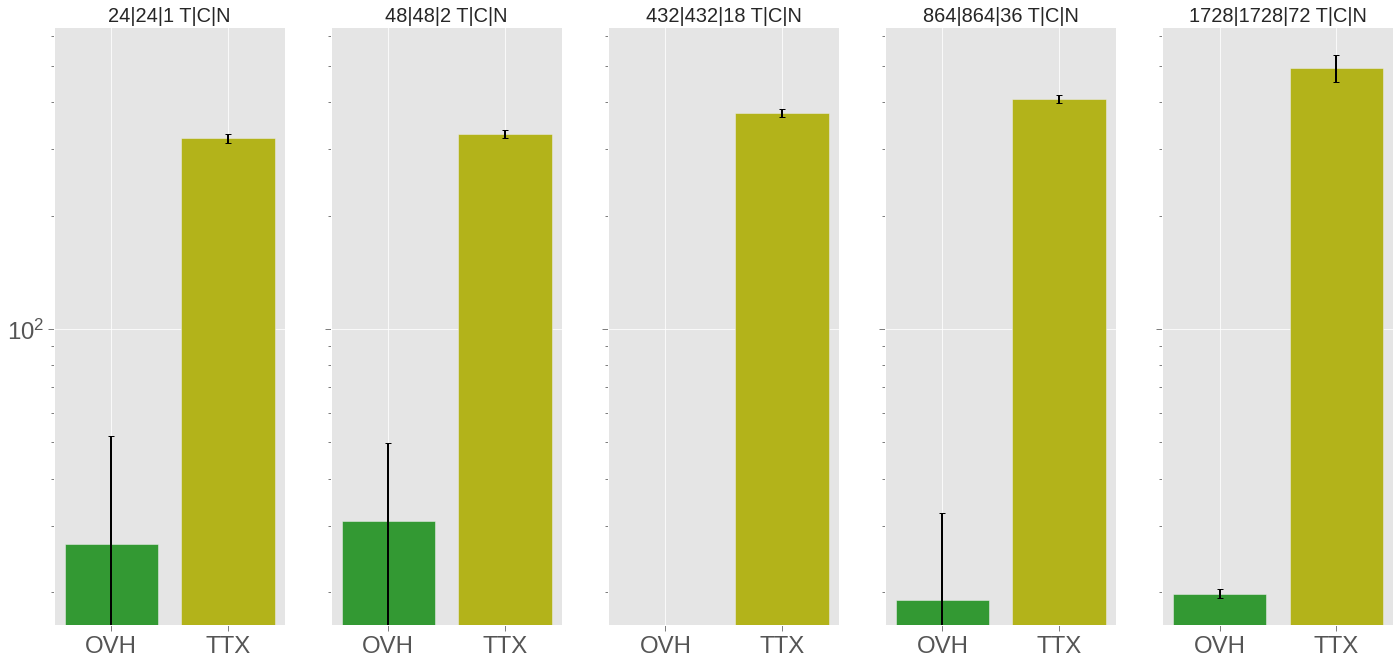

In [13]:
fwidth = 24
fhight = 11
fig, ax = plt.subplots(1, 5,sharey=True, figsize=(fwidth, fhight))

ax[0].set_title('24|24|1 T|C|N',fontsize= 20)
ax[0].bar(x = 'OVH', height = df_info['Parsl OVH'][0:3].mean(),yerr =df_info['Parsl OVH'][0:3].std() ,color = tableau20[4],log=True)
ax[0].bar(x = 'TTX', height = df_info['Parsl TTX'][0:3].mean(), yerr =df_info['Parsl TTX'][0:3].std(),color = tableau20[14],log=True)

ax[1].set_title('48|48|2 T|C|N',fontsize= 20)
ax[1].bar(x = 'OVH', height = df_info['Parsl OVH'][3:6].mean(),yerr =df_info['Parsl OVH'][3:6].std() ,color = tableau20[4],log=True)
ax[1].bar(x = 'TTX', height = df_info['Parsl TTX'][3:6].mean(), yerr =df_info['Parsl TTX'][3:6].std(),color = tableau20[14],log=True)

ax[2].set_title('432|432|18 T|C|N',fontsize= 20)
ax[2].bar(x = 'OVH', height = df_info['Parsl OVH'][6:9].mean(),yerr =df_info['Parsl OVH'][6:9].std() ,color = tableau20[4],log=True)
ax[2].bar(x = 'TTX', height = df_info['Parsl TTX'][6:9].mean(), yerr =df_info['Parsl TTX'][6:9].std(),color = tableau20[14],log=True)

ax[3].set_title('864|864|36 T|C|N',fontsize= 20)
ax[3].bar(x = 'OVH', height = df_info['Parsl OVH'][9:12].mean(),yerr =df_info['Parsl OVH'][9:12].std() ,color = tableau20[4],log=True)
ax[3].bar(x = 'TTX', height = df_info['Parsl TTX'][9:12].mean(), yerr =df_info['Parsl TTX'][9:12].std(),color = tableau20[14],log=True)

ax[4].set_title('1728|1728|72 T|C|N',fontsize= 20)
ax[4].bar(x = 'OVH', height = df_info['Parsl OVH'][12:14].mean(),yerr =df_info['Parsl OVH'][12:14].std() ,color = tableau20[4],log=True)
ax[4].bar(x = 'TTX', height = df_info['Parsl TTX'][12:14].mean(), yerr =df_info['Parsl TTX'][12:14].std(),color = tableau20[14],log=True)

plt.savefig('../Parsl/figures/parsl_ws_ttx_ovh.pdf', dpi=300, bbox_inches='tight')